In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    #'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Transformed_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    #'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Liver',
    'Lung',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


In [3]:
len(tissue_types)

44

In [4]:

version_suffix = '_lead'


median spearman r = 0.64, n = 1463.0
median p-value = 0.000401, n = 1463.0

unique snps = 366

median dir AP = 0.8
median sig AP = 0.65


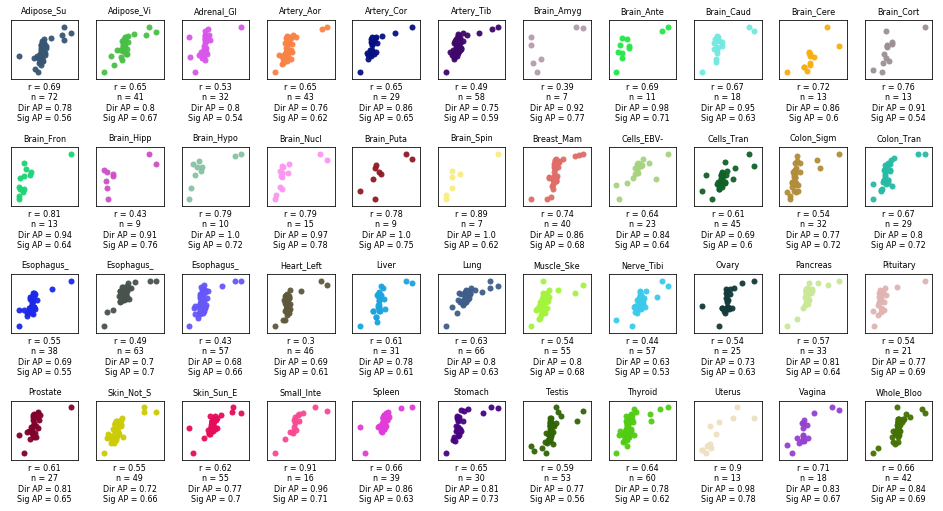

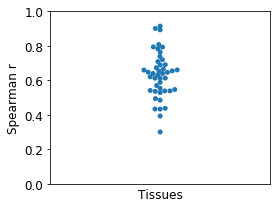

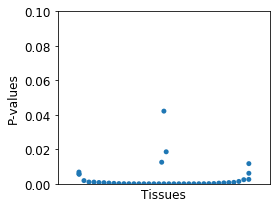

--- example tissue = 'Lung'
spearman r = 0.631
p-value = 1.3503909775187201e-08
n = 66


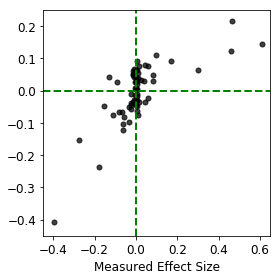

In [5]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = True

individual_plot_tissue_ix = tissue_types.index("Lung")

n_rows = 4
n_cols = 11

f, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

y_preds = []
y_trues = []

total_n = 0.

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_dict = {}

for i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv", sep='\t')
    snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    
    snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)
    
    snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105
    
    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

    snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])
    
    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')
    
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)
    
    lead_snp_pred_df_backup = lead_snp_pred_df
    
    filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'
    
    filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
    
    for _, row in filtered_df.iterrows() :
        if row['snp_id'] not in snp_dict :
            snp_dict[row['snp_id']] = True
    
    row = i // n_cols
    col = i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if x < 0. else 1).values)
    y_score = np.array(filtered_df['effect_size_pred'].values)
    
    dir_average_precision = average_precision_score(y_labels, y_score)

    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=0.5)

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(filtered_df['effect_size_pred'].values)

    sig_average_precision = average_precision_score(y_labels, y_score)

    if i < 49 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 2)) + "\nn = " + str(int(len(filtered_df))) + "\nDir AP = " + str(round(dir_average_precision, 2)) + "\nSig AP = " + str(round(sig_average_precision, 2)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        dir_ap_vals.append(dir_average_precision)
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]
    
    y_preds.append(y_pred)
    y_trues.append(y_true)

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

print('median spearman r = ' + str(round(np.median(spearman_r_vals), 2)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals), 6)) + ', n = ' + str(total_n))

print("")
print("unique snps = " + str(len(snp_dict)))
print("")

print('median dir AP = ' + str(round(np.median(dir_ap_vals), 2)))
print('median sig AP = ' + str(round(np.median(sig_ap_vals), 2)))

if save_figs :
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_pred_aparent_resnet_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)])

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)])

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_p_value_swarm" + version_suffix + ".eps")

plt.show()

#Individual plot for selected example tissue
r_val, p_val = spearmanr(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix])

print("--- example tissue = '" + tissue_types[individual_plot_tissue_ix] + "'")
print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(y_trues[individual_plot_tissue_ix].shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_preds[individual_plot_tissue_ix], y_trues[individual_plot_tissue_ix], color='black', s=25, alpha=0.75)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

plt.xlim(-0.45, 0.65)
plt.ylim(-0.45, 0.25)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted Effect Size", fontsize=12)
plt.xlabel("Measured Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_example" + version_suffix + ".eps")

plt.show()


In [11]:
#Save r-values and p-values

np.save('gtex_tissue_spearman_r_vals_aparent_resnet', np.array(spearman_r_vals))
np.save('gtex_tissue_spearman_p_vals_aparent_resnet', np.array(spearman_p_vals))
np.save('gtex_tissue_ns_aparent_resnet', np.array(ns))


In [6]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

spearman_r_vals_multi = []
spearman_p_vals_multi = []
ns_multi = []

dir_ap_vals_multi = []
sig_ap_vals_multi = []

total_n_multi = []

blacklist_ids = [
    'chr5_76728085_C_T'
]

for p_thresh in [1., 1e-5, 1e-10, 1e-20, 1e-40] :

    spearman_r_vals = []
    spearman_p_vals = []
    ns = []

    dir_ap_vals = []
    sig_ap_vals = []

    total_n = 0.
    
    snp_dict = {}
    
    print("Predicting for p-value threshold = " + str(p_thresh))

    for i, tissue_type in enumerate(tissue_types) :

        snp_pred_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv", sep='\t')
        snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

        snp_pred_df = snp_pred_df.query("p_val < " + str(p_thresh)).copy().reset_index(drop=True)

        snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

        snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

        #PDUI
        snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
        snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

        snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

        lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

        lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

        lead_snp_pred_df_backup = lead_snp_pred_df

        filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

        filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
        
        for _, row in filtered_df.iterrows() :
            if row['snp_id'] not in snp_dict :
                snp_dict[row['snp_id']] = True

        y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
        y_true = np.ravel(np.array(filtered_df['effect_size'].values))

        spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)

        y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if x < 0. else 1).values)
        y_score = np.array(filtered_df['effect_size_pred'].values)

        dir_average_precision = average_precision_score(y_labels, y_score) if np.unique(y_labels).shape[0] > 1 else 0.

        q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=0.5) if len(filtered_df) > 1 else 0.

        y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
        y_score = np.array(filtered_df['effect_size_pred'].values)

        sig_average_precision = average_precision_score(y_labels, y_score) if np.unique(y_labels).shape[0] > 1 else 0.

        if not np.isnan(spearman_r_val) :
            spearman_r_vals.append(spearman_r_val)
            spearman_p_vals.append(spearman_p_val)
            ns.append(int(len(filtered_df)))

            dir_ap_vals.append(dir_average_precision)
            sig_ap_vals.append(sig_average_precision)

        total_n += y_pred.shape[0]
    
    spearman_r_vals_multi.append(np.array(spearman_r_vals))
    spearman_p_vals_multi.append(np.array(spearman_p_vals))
    ns_multi.append(np.array(ns))

    dir_ap_vals_multi.append(np.array(dir_average_precision))
    sig_ap_vals_multi.append(np.array(sig_average_precision))

    total_n_multi.append(total_n)
    
    print("unique snps = " + str(len(snp_dict)))


Predicting for p-value threshold = 1.0
unique snps = 366
Predicting for p-value threshold = 1e-05
unique snps = 283
Predicting for p-value threshold = 1e-10
unique snps = 142
Predicting for p-value threshold = 1e-20
unique snps = 61
Predicting for p-value threshold = 1e-40
unique snps = 25


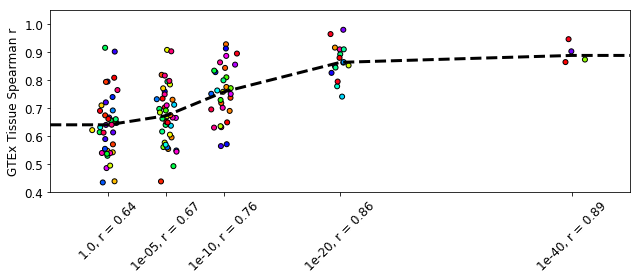

In [8]:

save_figs = True

p_threshes = [1., 1e-5, 1e-10, 1e-20, 1e-40]

max_p_val = None
min_n = 10

r_vals = []
r_medians = []

for i in range(len(spearman_r_vals_multi)) :
    
    rs = spearman_r_vals_multi[i]
    ps = spearman_p_vals_multi[i]
    ns = ns_multi[i]
    
    if max_p_val is not None :
        r_vals.append(rs[ps < max_p_val])
        r_medians.append(np.median(rs[ps < max_p_val]))
    elif min_n is not None :
        r_vals.append(rs[ns >= min_n])
        r_medians.append(np.median(rs[ns >= min_n]))
    else :
        r_vals.append(rs)
        r_medians.append(np.median(rs))

import seaborn as sns

f = plt.figure(figsize=(9, 4))

for i in range(len(r_vals)) :
    
    p_thresh = -np.log(p_threshes[i]) / np.log(10.)
    
    xs = np.ones(r_vals[i].shape[0]) * p_thresh + np.random.normal(loc=0., scale=0.5, size=(r_vals[i].shape[0], )) 
    cs = np.random.uniform(low=0., high=1., size=(r_vals[i].shape[0],))
    
    plt.scatter(xs, r_vals[i], s=25, edgecolor='black', linewidth=1, cmap='hsv', c=cs)
    
plt.plot([-np.log(100000.0) / np.log(10.0)] + [-np.log(p_thresh) / np.log(10.) for p_thresh in p_threshes] + [-np.log(1e-45) / np.log(10.0)], [r_medians[0]] + r_medians + [r_medians[-1]], linewidth=3, linestyle="--", color='black')

plt.xticks([-np.log(p_thresh) / np.log(10.) for p_thresh in p_threshes], [str(m)+ ", r = " + str(round(r_medians[m_i], 2)) for m_i, m in enumerate(p_threshes)], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.xlim(-np.log(100000.0) / np.log(10.0), -np.log(1e-45) / np.log(10.0))
plt.ylim(0.4, 1.05)

plt.ylabel("GTEx Tissue Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_aparent_resnet_r_traj" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_aparent_resnet_r_traj" + version_suffix + ".eps")

plt.show()


Direction AP = 0.714
Significant AP (qtl = 0.051) = 0.602
spearman r = 0.527
p-value = 1.569436658195398e-14
n = 184


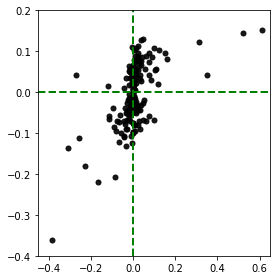

In [5]:
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr, pearsonr

save_figs = True

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_pred_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv", sep='\t')

snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

#PDUI
snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

filtered_df = lead_snp_pred_df.query("n_tissues > 1 and snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]

#Compute classification score
y_labels = np.array(filtered_df['effect_size_median'].apply(lambda x: 0 if x < 0. else 1).values)
y_score = np.array(filtered_df['effect_size_pred'].values)

average_precision = average_precision_score(y_labels, y_score)

print("Direction AP = " + str(round(average_precision, 3)))

q_val = np.quantile(np.abs(filtered_df['effect_size_median'].values), q=0.5)

y_labels = np.array(filtered_df['effect_size_median'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
y_score = np.array(filtered_df['effect_size_pred'].values)

average_precision = average_precision_score(y_labels, y_score)

print("Significant AP (qtl = " + str(round(q_val, 3)) + ") = " + str(round(average_precision, 3)))

#Plot predictions
r_val, p_val = spearmanr(filtered_df['effect_size_pred'], filtered_df['effect_size_median'])

print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['effect_size_pred'], filtered_df['effect_size_median'], color='black', s=25, alpha=0.9)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

plt.xlim(-0.45, 0.65)
plt.ylim(-0.4, 0.2)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_median_scatter_n_tissues_2.png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_median_scatter_n_tissues_2.eps")

plt.show()


Direction AP = 0.63
Significant AP (qtl = 0.043) = 0.557
spearman r = 0.369
p-value = 3.1705777307319706e-13
n = 366


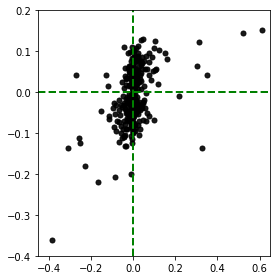

In [6]:
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr, pearsonr

save_figs = True

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_pred_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_predictions_pred_df.csv", sep='\t')

snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

#PDUI
snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

filtered_df = lead_snp_pred_df.query("n_tissues > 0 and snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]

#Compute classification score
y_labels = np.array(filtered_df['effect_size_median'].apply(lambda x: 0 if x < 0. else 1).values)
y_score = np.array(filtered_df['effect_size_pred'].values)

average_precision = average_precision_score(y_labels, y_score)

print("Direction AP = " + str(round(average_precision, 3)))

q_val = np.quantile(np.abs(filtered_df['effect_size_median'].values), q=0.5)

y_labels = np.array(filtered_df['effect_size_median'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
y_score = np.array(filtered_df['effect_size_pred'].values)

average_precision = average_precision_score(y_labels, y_score)

print("Significant AP (qtl = " + str(round(q_val, 3)) + ") = " + str(round(average_precision, 3)))

#Plot predictions
r_val, p_val = spearmanr(filtered_df['effect_size_pred'], filtered_df['effect_size_median'])

print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['effect_size_pred'], filtered_df['effect_size_median'], color='black', s=25, alpha=0.9)

plt.axvline(x=0., linewidth=2, linestyle='--', color='green')
plt.axhline(y=0., linewidth=2, linestyle='--', color='green')

plt.xlim(-0.45, 0.65)
plt.ylim(-0.4, 0.2)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_median_scatter_n_tissues_1.png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_aparent_resnet_median_scatter_n_tissues_1.eps")

plt.show()


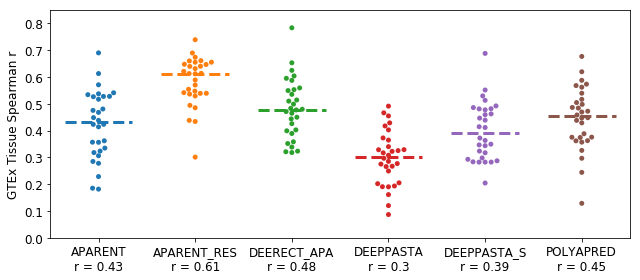

In [11]:
#Compare predictor r-values

save_figs = True

model_names = [
    'aparent',
    'aparent_resnet',
    'deerect_apa',
    'deeppasta',
    'deeppasta_sp',
    'polyapred',
]

max_p_val = None#0.01
min_n = 20

r_vals = []
r_medians = []

for i, model_name in enumerate(model_names) :
    
    rs = np.load('gtex_tissue_spearman_r_vals_' + model_name + '.npy')
    ps = np.load('gtex_tissue_spearman_p_vals_' + model_name + '.npy')
    ns = np.load('gtex_tissue_ns_' + model_name + '.npy')
    
    if max_p_val is not None :
        r_vals.append(rs[ps < max_p_val])
        r_medians.append(np.median(rs[ps < max_p_val]))
    elif min_n is not None :
        r_vals.append(rs[ns >= min_n])
        r_medians.append(np.median(rs[ns >= min_n]))
    else :
        r_vals.append(rs)
        r_medians.append(np.median(rs))

import seaborn as sns

f = plt.figure(figsize=(9, 4))

ax = sns.swarmplot(data=r_vals)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, r_m in enumerate(r_medians) :
    plt.plot([i - 0.35, i + 0.35], [r_m, r_m], linewidth=3, linestyle="--", color=colors[i])

plt.xticks(np.arange(len(r_vals)), [m.upper()[:11] + "\nr = " + str(round(r_medians[m_i], 2)) for m_i, m in enumerate(model_names)], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.85)

plt.ylabel("GTEx Tissue Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_benchmark_r_value_swarms" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_benchmark_r_value_swarms" + version_suffix + ".eps")

plt.show()
